In [98]:
import sys
!{sys.executable} -m pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
nltk.download('punkt_tab')

# Importing required libraries

This project uses tensorflow keras and nltk library for natural language processing to process user responses in order to build a medical chatbot. 

In [100]:
import nltk
nltk.download('punkt')
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()
import numpy as np
import tensorflow as tf
import random
import json
import pickle
from tensorflow import keras
from tensorflow.keras import layers

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data set

Data set from kaggle composed of medical questions and answqers. 
[Medical Chat Bot Kaggle Dataset](https://www.kaggle.com/code/zzettrkalpakbal/medical-chat-bot/input)


In [101]:
with open('Medical_Chatbot_128/intents.json') as f:
    data = json.load(f)

# Data preprocessing and model develepment

This section of the code prepares the data for training a chatbot model by extracting and processing the intents and their associated patterns. It tokenizes the patterns using NLTK, stems the words, and constructs a bag-of-words representation, ensuring that each unique word is accounted for.

The model is a sequential model composed of 2 hidden layers and an input and output layer, a softmax activation is used in the output layer, and categorical_crossentropy is the loss function. Adam optimizer was used. The model is composed of a total of 1,388 trainable parameters. 

In [102]:
words = []
labels = []
docs_x = []
docs_y = []

for intent in data["intents"]:
  for pattern in intent["patterns"]:
    wrds = nltk.word_tokenize(pattern)
    words.extend(wrds)
    docs_x.append(wrds)
    docs_y.append(intent["tag"])


  if intent["tag"] not in labels:
    labels.append(intent["tag"])  

words = [stemmer.stem(w.lower()) for w in words if  w not in "?"]
words = sorted(list(set(words)))

labels = sorted(labels)

training = []
output = []

out_empty = [0 for _ in range(len(labels))]

for x,doc in enumerate(docs_x):
  bag = []
  wrds = [stemmer.stem(w) for w in doc]

  for w in words:
    if w in wrds:
      bag.append(1)
    else:
      bag.append(0)

  output_row = out_empty[:]
  output_row[labels.index(docs_y[x])] = 1

  training.append(bag)
  output.append(output_row)

training = np.array(training)
output = np.array(output)

model = keras.Sequential([
    layers.Input(shape=(len(training[0]),)),
    layers.Dense(8,),
    layers.Dense(8,),
    layers.Dense(len(output[0]), activation='softmax')
])


In [103]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 8)                 920       
                                                                 
 dense_22 (Dense)            (None, 8)                 72        
                                                                 
 dense_23 (Dense)            (None, 44)                396       
                                                                 
Total params: 1,388
Trainable params: 1,388
Non-trainable params: 0
_________________________________________________________________


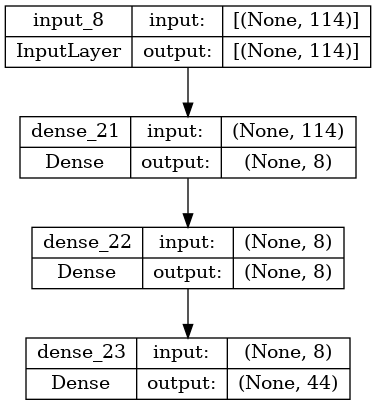

In [110]:
model.summary()  # Print the model summary

# Save the model architecture to a PNG file
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [104]:
model.fit(training, output, epochs=250, batch_size=8, verbose=1)

Train on 188 samples
Epoch 1/250
188/188 [==============================] - 0s 244us/sample - loss: 3.7994 - acc: 0.0319
Epoch 2/250
188/188 [==============================] - 0s 56us/sample - loss: 3.7653 - acc: 0.0426
Epoch 3/250
188/188 [==============================] - 0s 58us/sample - loss: 3.7349 - acc: 0.0585
Epoch 4/250
188/188 [==============================] - 0s 53us/sample - loss: 3.7063 - acc: 0.0691
Epoch 5/250
188/188 [==============================] - 0s 55us/sample - loss: 3.6741 - acc: 0.0904
Epoch 6/250
188/188 [==============================] - 0s 54us/sample - loss: 3.6402 - acc: 0.1117
Epoch 7/250
188/188 [==============================] - 0s 56us/sample - loss: 3.6030 - acc: 0.1330
Epoch 8/250
188/188 [==============================] - 0s 59us/sample - loss: 3.5607 - acc: 0.1755
Epoch 9/250
188/188 [==============================] - 0s 55us/sample - loss: 3.5134 - acc: 0.2021
Epoch 10/250
188/188 [==============================] - 0s 54us/sample - loss: 3.4599 -

In [105]:
model.save("model.h5")

In [109]:
import pydot

# Deployment of the chatbot

This part of the code defines a function to create a bag-of-words representation from user input, enabling the chatbot to understand and respond to user queries. The chat function prompts the user for input in a loop, processes the input to generate a feature vector, and uses the trained model to predict the intent. Based on the predicted intent, it selects appropriate responses and formats them for display, enhancing the interaction with colorful output for better readability.

In [106]:
def bag_of_words(s, words):
  bag = [0 for _ in range(len(words))]

  s_words = nltk.word_tokenize(s)
  s_words = [stemmer.stem(word.lower()) for word in s_words]

  for se in s_words:
    for i, w in enumerate(words):
      if w == se:
        bag[i] = 1

  return np.array(bag)

In [107]:
def chat():
  print("\033[1;31m Start talking with the bot!, Type quit when you want to quit")
  while True:
    inp = input("\033[1;31m You: ")
    if inp.lower() == "quit":
      break
        
    bag = bag_of_words(inp, words).reshape(1, -1)  # Ensure it's 2D
    results = model.predict(bag)
    results_index = np.argmax(results)
    tag = labels[results_index]

    for tg in data["intents"]:
      
      if tg['tag'] == tag:
        
        responses = tg['responses']

        response_list = nltk.sent_tokenize(str(responses[0]))
        colors = [31, 32, 33, 34, 35]

        for i in range(len(response_list)):
            color_index = i % len(colors)
            print(f'\033[1;{colors[color_index]}m {response_list[i]:<12s}\n')

In [108]:
chat()

 Start talking with the bot!, Type quit when you want to quit


 You:  fevee


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


 To treat a fever at home: 1)Drink plenty of fluids to stay hydrated.

 2)Dress in lightweight clothing.

 3)Use a light blanket if you feel chilled, until the chills end.

 4)Take acetaminophen (Tylenol, others) or ibuprofen (Advil, Motrin IB, others).

 5) Get medical help if the fever lasts more than five days in a row.



 You:  q


 1)Move the person out of the heat and into a shady or air-conditioned place.

 Lay the person down and elevate the legs and feet slightly.

 Remove tight or heavy clothing.

 Have the person drink cool water or other nonalcoholic beverage without caffeine



 You:  qyit


 1)Move the person out of the heat and into a shady or air-conditioned place.

 Lay the person down and elevate the legs and feet slightly.

 Remove tight or heavy clothing.

 Have the person drink cool water or other nonalcoholic beverage without caffeine



 You:  quit


In [111]:
import os

In [112]:
save_dir = 'Medical_Chatbot_128'
os.makedirs(save_dir, exist_ok=True)

In [113]:
# Save model weights
model.save_weights(os.path.join(save_dir, "weights.h5"))

# Save the entire model with a filename
model.save(os.path.join(save_dir, "model.h5"))